# Small Cell Network: Parametrized MDP- MatricizedModel

### Problem Setting:

The system consists of $n$ nodes which receive cellular traffic. the data packets are routed to a central destination tower via intermediate small cell towers which are $f$ in number. at any incident node or intermediate cell-tower, we can decide the next facility/cell-tower for the data-packet. the __cost__ incurred in the action is equal to the physical distance between the incident node/cell-tower to the assigned cell-tower. The objective is to minimize the expected routing cost from any node to the destination, via selection of a optimal policy (i.e assignment of next cell-tower/destination from any tower/node) and optimizing the placement of intermediate cell-towers (cell-tower locations (x, y coordinates) are the paramaters of the model to be optimized).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools;
import math;
import scipy.io as scio;

n = 46; #number of initital nodes for data
f = 5; #number of resources/facilities/small-cell towers

V_VI = np.zeros((n+f+1));                                     #Initialisation of Value Function array for VI
V_new_VI = np.zeros((n+f+1));

V_MPI = np.zeros((n+f+1));                                     #Initialisation of Value Function array for MPI
V_new_MPI = np.zeros((n+f+1));

action = np.zeros((n+f+1));

# MDP model definition

### here we deifine the probability tranisiton model for the Small-cell optimization problem...

First we start with the definition of the state space for the model

from the problem defintion it is clear that the node, facility/cell-tower or destination location for the data-packet is the state of the system.

$s \in \{0\} := $ destination state

$s \in \{1, \ldots, f\} := $ cell-tower state

$s \in \{f+1,\ldots, n+f+1\} := $ node states

In [2]:
#define the state space and vectors here..
state_space = np.linspace(0, n+f, n+f+1, dtype = int)
state_space = [(s,) for s in state_space];
print(state_space)

[(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48,), (49,), (50,), (51,)]


### Next we define the action space for the system.

Now for action space the definition is comparatively simple. Since we can control the next facility/cell-tower or destination that the data packet goes to (__not a node, only cell-towers or destination__), the action space is just the next fcell-tower/destination state index

$a \in \{0\} := $ goto destination

$a \in \{1, \ldots, f\} := $ goto cell-tower a


In [3]:
#define the action space of teh system...
act_space = np.linspace(0, f,f+1, dtype = int);
act_space = [(a,) for a in act_space];
print(act_space);

[(0,), (1,), (2,), (3,), (4,), (5,)]


In [4]:
act_mask = np.zeros(shape=(52, 6));
# print(smallcell1.setState(3));
# act_mask[0, smallcell1.get_actions()] = 1;
# act_mask[0]

With the state and action spaces defined, we now move forward to defining the system model.

## System Model definition

For the system, the model is quite simple. The action represents the next cell-tower/destination ower for the packet to be routed from the present state of the system. The transition of the system from one state to another is deterministic, i.e. action of routing of a packet from one state to the next results in the packet to the routed to the destined next state w.p. 1.

The difficult part is the cost of the routing, the cost of routing from one state to the next is defined as the physical distance between the concerned points. For the model, the nodes, cell-tower and destination positions are considered to be two-dimensional datapoints in space, of which, the node and destination points fixed whereas the cell-tower coordinates are the parameters which must also be optimized.




In [5]:
#define the model here as a class
class SmallCellNet():

    #firstly define the data member for the model
    n: int; #number of nodes,
    f: int; #number of cell towers;
    nodeLocations: np.ndarray; #nx2 matrix including the node coordinates (fixed)
    cellLocations: np.ndarray; #nx2 matrix storing the cell-tower locations (changable)
    destinationLocation: np.ndarray; #1x2 matrix storing the destination location (fixed)#
    st:int;
    reward2cost:int;

    #define a probability transition matrix for the model.... (s,a) -> nextState
    P:np.ndarray;
    #define a cost function matrix for the transition (s,a) -> nextState
    C:np.ndarray;
    #define a gradient matrix wrt for each (s, a, s') for each parameters
    G:np.ndarray;
    #define a an action mask sxa dimensional matrix
    action_mask:np.ndarray;


    #define the constructor
    def __init__(self, n:int, f:int, locations_path:str, init_state = 0):
        '''
        function initializes the small cell network model.
        n: number of starting nodes,
        f: number of intermediate cell-towers
        location_path: path to a mat file to get the node, destination and initialize the cell tower locations
        '''

        #firstly set the number of states, facilities to the mentioned values
        self.n = n;
        self.f = f;
        #now load the mat file from the path and get the locations
        data = scio.loadmat(locations_path);
        #get the params
        para = data['para']; #using Amber's mat file of loactions for now.....TODO: Change this later to make more generic..
        #7th onwards are the nodes
        self.nodeLocations = para[6:, :];
        self.destinationLocation = np.array([[4., 7.]]);
        self.st = init_state;
        self.init_params(); #initialize parameters through the function

        #fnally define the state and action space for the model
        self.state_space = [(s,) for s in np.linspace(0, n+f, n+f+1, dtype = int)];
        self.action_space = [(a,) for a in np.linspace(0, f, f+1, dtype = int)];

        #finally initialize the probability, cost, action mask and gradient tensors..
        self.init_probab_matrix();
        self.init_cost_matrix();
        self.init_action_mask();
        self.init_grad_matrix();
    
    #define a function to inidialize the probability transition
    def init_probab_matrix(self): ##Exclusive to the matricized version of the algorithm
        '''
        function initializes the probability transition matrix for matriced algorithms
        probability transition matrix is sxaxs dimensional tensor (3d tensor)
        '''
        #start with an initial zeros matrix
        #now for any state action pair, we must assign the corresponding probability of going to the next state
        #w.p 0.9 goto the state mentioned in the action
        self.P = np.tile(np.expand_dims(np.eye(*self.act_space_shape(),*self.state_space_shape()), axis=0), (*self.state_space_shape(),1,1))*0.9;
        #and the destination gets an additional 0.1 probability....bcoz we goto destinaition with probability 0.1
        self.P[:,:,0] += 0.1;
        pass;
    
    #define a function to initialize the cost matrix
    def init_cost_matrix(self):
        #create the vector for the locations
        # X = np.vstack([self.destinationLocation, self.cellLocations, self.nodeLocations]); #nx2 matrix
        C_interm = np.sum(self.X**2, axis=1, keepdims=True) + np.sum(self.X**2, axis=1, keepdims=True).T - 2*(self.X @ self.X.T);
        C_interm[1:self.f+1,0] -= 50; #incentive to goto destination;
        # finally expand the cost function along the second dimentsion to replicate it for all the actions
        self.C = np.tile(np.expand_dims(C_interm, axis=1), (1, *self.act_space_shape(), 1));
        pass;
    
    #define a function to update cost matrix..after change of parameters
    def update_cost_matrix(self):
        
        C_interm = np.sum(self.X**2, axis=1, keepdims=True) + np.sum(self.X**2, axis=1, keepdims=True).T - 2*(self.X @ self.X.T);
        C_interm[1:self.f+1,0] -= 50; #incentive to goto destination;
        # finally expand the cost function along the second dimentsion to replicate it for all the actions
        self.C = np.tile(np.expand_dims(C_interm, axis=1), (1, *self.act_space_shape(), 1));
        pass;
    
    #define a function to iniitalize the gradient wrt parameters for each sxaxs combintation
    def init_grad_matrix(self):
        '''
        initialize the gradient w.r.t parameter tensor which is a state x action x nextState x parameter dimensional tensor..
        '''
        G = np.zeros(shape = (*self.state_space_shape(), * self.state_space_shape(), self.f*2)); #*self.act_space_shape()

        # [s, ns, p] = np.meshgrid(self.state_space, self.state_space, range(self.f*2))

        #lets loop through the states and parameters..
        for p in range(self.f):
            G[p+1,:,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            G[p+1,:,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
            G[:,p+1,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            G[:,p+1,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
        
        #now populate the required elements of the matrix
        self.G = np.tile(np.expand_dims(G, axis=1), (1, *self.act_space_shape(), 1, 1));
        pass;
    
    #define a function to update the gradient tensor
    def update_grad_matrix(self):
        '''
        Update the gradient w.r.t parameter tensor which is a state x action x nextState x parameter dimensional tensor..
        '''
        G = np.zeros(shape = (*self.state_space_shape(), * self.state_space_shape(), self.f*2)); #*self.act_space_shape()

        # [s, ns, p] = np.meshgrid(self.state_space, self.state_space, range(self.f*2))

        for p in range(self.f):
            G[p+1,:,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            G[p+1,:,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
            G[:,p+1,2*p] = (self.X[p+1,0] - self.X[:,0])*2;
            G[:,p+1,(2*p)+1] = (self.X[p+1,1] - self.X[:,1])*2;
        
        #now populate the required elements of the matrix
        self.G = np.tile(np.expand_dims(G, axis=1), (1, *self.act_space_shape(), 1, 1));
        pass;
    
    #define function to get the shape of hte state and action space
    def state_space_shape(self):
        return (self.n + self.f + 1,);
    
    #define a function to get the sacyion space dimensions
    def act_space_shape(self):
        return (self.f+1,);
    
    #define a function to initialize the parameters for the model
    def init_params(self):
        #initialize the model parametrs to all zeros
        self.cellLocations = np.zeros(shape=(self.f, 2));
        self.X = np.vstack([self.destinationLocation, self.cellLocations, self.nodeLocations]); #nx2 matrix

        self.init_cost_matrix();
        self.init_grad_matrix();
        pass;
    
    #define a function to get the parameters for the model
    def parameters(self) -> np.ndarray:

        '''
        function returns a list of parameters for the system.
        '''

        #return the cell locations as the parameters list. each coordinate is a scalar parameter..
        return self.cellLocations.reshape(-1);
    
    #define a function to update the parameters to a new value
    def update_params(self, params: np.ndarray):
        '''
        function to udate the list of paramaters for the model to a new set of parameters
        params: updated list f parameters of the same length and shape of elements as in self.parameters()
        return :
        None
        '''

        #firstly check if the number of parameters in the list match
        assert(params.shape == self.parameters().shape);

        #now go over each parameter in the list and update the corresponding model parameter
        # for i in range(len(params)):
        #     #assign the correspondin parameter after checking the dimension
        #     # in this case of small cell network every parameter element is a coordinate in the cellLocations matrix.
        #     # assert(params[i].shape == 1);
        #     self.cellLocations[int(i/2), i%2] = params[i];
        
        self.cellLocations = params.reshape(-1,2);

        #before updating the cost and gradient tensors...update the self.X vector with the updated parameters.
        self.X[1:self.f+1,:] = self.cellLocations;

        #once parameters are updated...update the cost and gradient tensors for the model..
        self.update_cost_matrix();
        self.update_grad_matrix();

        pass;
    
    #define a function to set the system state
    def setState(self, state):
        #just set the state
        assert((state <= self.n + self.f) & (state>=0));
        self.st = state;
        pass;
    
    def state(self):
        return (self.st,);
    
    #define a function to list the avaiable action for the state
    def get_actions(self):
        '''
        return:
        action_list: list of actions available for the present state of the system
        '''
        #here the action list is independent of the state that one is in, except for the the destination state, wherein the only
        # avaiable action is to stay there
        action_list =[(0,)];

        if(self.st == 0):
            #only zero is the action possible at 0
            return [(0,)];
        else:
            #return the entire action space for the model
            test = self.action_space.copy();
            if((self.st>=1)&(self.st<=self.f)):
                test.remove((self.st,));
            else:
                test.remove((0,)); #cannot go from node directly to destination
            return test;
    
    #define a functino to define the action mask for the model....for matricized implementation
    def init_action_mask(self): #Specifically for matricized implementation...
        '''
        function initializes the action mask for the model....i.e the boolean tensor of state x action dimensions to represent
        allowable action from the model..
        '''
        self.action_mask = np.ones(shape = (*self.state_space_shape(), *self.act_space_shape()));
        self.action_mask[self.f+1:, 0] = 0; #cannot go from any node directly to the destination
        self.action_mask[0,:] = 0; self.action_mask[0,0] = 1; #only action allowed at destination is the destination itself..
        self.action_mask[1:self.f+1, 1:self.f+1] -= np.eye(self.f, self.f); # from any facility location self-loop is not possible
        pass;
    
    #next define the function to step from a given state to the using the actions and probabilities of arrival/departure events..
    def step(self, act) -> list:

        '''
        act: action on the state to direct to the next state...,

        returns:
        state_prob_dict_array: an array dictionary of possible next states for the system, the corresponding reward and the
        associated probability of transition to those states. also a list with the gradient of the cost/reward w.r.t parameters (in same order as parameters) is returned
        if parameters are present else an empty list is returned.
        '''

        assert((act >= 0) & (act <= self.f));

        #the model is deterministic, hence the stepping action leads to one state w.p. 1

        #firstly check the whether the action can be performed
        if(self.st == 0):
            #the model is at terminal state, thus w.p. 1 the next state is the terminal state itself, cost is zero and
            # the gradient w.r.t parameters is also zero
            return [[(0,), 0, 1, [0]*(2*self.f)]];
        
        else:

            #now, there is actually some state transition and costs associated with the transition

            grads = [0]*(2*self.f);

            #the starting state is the present state, thus at the 
            prosp_state = act; #the action is the prospective state
            p = 0.9; #probablity 1
            #determine the cost at the squared 2-norm between the two point
            if(self.st >= self.f+1):
                pt1 = self.nodeLocations[self.st - self.f - 1, :];
                #no gradient wrt node location
                g1 = -1;
            elif((self.st >= 1)&(self.st <= self.f)):
                pt1 = self.cellLocations[self.st-1, :]; #a cell location is the present state
                #gradient w.r.t cell location is present
                g1 = self.st-1;
            else:
                pt1 = self.destinationLocation[0, :];
                g1 = -1;
            
            #same for next point..no check w.r.t node location because its not in the action space
            if((prosp_state >= 1)&(prosp_state <= self.f)):
                pt2 = self.cellLocations[prosp_state-1, :]; #a cell location is the next state
                #gradient w.r.t cell location is present
                g2 = prosp_state-1;
            else:
                pt2 = self.destinationLocation[0, :];
                g2 = -1;
            
            if(g1!=-1):
                grads[2*g1] = 2*(pt1[0] - pt2[0]); grads[(2*g1)+1] = 2*(pt1[1] - pt2[1]);
            if(g2!=-1):
                grads[2*g2] = 2*(pt2[0] - pt1[0]); grads[(2*g2)+1] = 2*(pt2[1] - pt1[1]);
            
            #and the cost is the euclidean norm
            cost = np.linalg.norm(pt1-pt2, 2)**2;
            if((prosp_state == 0)&(self.st >= 1)&((self.st <= self.f))):
                cost -= 50;

            state_prob_dict = [[(prosp_state,), cost, p, grads]];

            #with small probability.... goto destination
            grads = [0]*(2*self.f);

            #the starting state is the present state, thus at the 
            prosp_state = 0; #the action is the prospective state
            p = 0.1; #probablity 0.1
            #determine the cost at the squared 2-norm between the two point
            if(self.st >= self.f+1):
                pt1 = self.nodeLocations[self.st - self.f - 1, :];
                #no gradient wrt node location
                g1 = -1;
            elif((self.st >= 1)&(self.st <= self.f)):
                pt1 = self.cellLocations[self.st-1, :]; #a cell location is the present state
                #gradient w.r.t cell location is present
                g1 = self.st-1;
            else:
                pt1 = self.destinationLocation[0, :];
                g1 = -1;
            
            #same for next point..nothing doing, its the destination
            pt2 = self.destinationLocation[0, :];
            g2 = -1;
            
            if(g1!=-1):
                grads[2*g1] = 2*(pt1[0] - pt2[0]); grads[(2*g1)+1] = 2*(pt1[1] - pt2[1]);
            if(g2!=-1):
                grads[2*g2] = 2*(pt2[0] - pt1[0]); grads[(2*g2)+1] = 2*(pt2[1] - pt1[1]);
            
            #and the cost is the euclidean norm
            cost = np.linalg.norm(pt1-pt2, 2)**2;
            if((prosp_state == 0)&(self.st >= 1)&((self.st <= self.f))):
                cost -= 50;

            state_prob_dict.append([(prosp_state,), cost, p, grads]);

            return state_prob_dict;


In [6]:
smallcell1 = SmallCellNet(46, 5, "E:\\mustafa\\_Btech mech\\Salapaka Reseach Group\\Matlab\\ParaMDP\\para3.mat");
print(smallcell1.X.shape)
print(smallcell1.state())
smallcell1.setState(10)
print(smallcell1.get_actions());
print(smallcell1.cellLocations[3])
print(smallcell1.step(0));
smallcell1.init_probab_matrix();
smallcell1.init_cost_matrix();
smallcell1.init_action_mask();
# print(np.sum(smallcell1.P, axis=-1));
print(smallcell1.C.shape);
print(smallcell1.action_mask.shape);
print(smallcell1.G[0,0,5])

(52, 2)
(0,)
[(1,), (2,), (3,), (4,), (5,)]
[0. 0.]
[[(0,), 26.63411463483864, 0.9, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [(0,), 26.63411463483864, 0.1, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]
(52, 6, 52)
(52, 6)
[  0.   0.   0.   0.   0.   0.   0.   0.  -8. -14.]


# Define the Optimizaton Routine.
With the GPU system model defined, we now define the optimization routines for the model using value and modified policy iteration.

## Q-function iteration with MEP (Known MDP)

Here we carry out the fixed point iterations for the optimal bellman operator obtained for optimal solution for MDP with maximized entropy. The objective of the optimization problem is to __minimize__ the expected discounted sum of costs over the trajectory through the policy, while maximizing the entopy of the state-action path. The resulting fixed point equation to be solved is as follows.

$ \Lambda_{\beta}(s,a) = (T\Lambda_{\beta})(s,a) $

where T is the optimal bellman operator, given as,

$ (T\Lambda_{\beta})(s,a) = \sum\limits_{s' \in \mathscr{S}} \left[ p_{ss'}^{a} \left( c_{ss'}^{a} + \frac{\gamma}{\beta}log(p_{ss'}^{a}) \right) \right] -\frac{\gamma^{2}}{\beta} \sum\limits_{s' \in \mathscr{S}} p_{ss'}^{a} log\left[ \sum\limits_{a' \in \mathscr{A}} exp\left\lbrace \frac{-\beta}{\gamma}\Lambda_{\beta}(s',a') \right\rbrace \right] $

Now, to account for actions that cannot be performed at a particular state, the above expression is augmented with the action mask $M(.,.)$ in all operations to eliminate the effect of prohibited actions based on states

$ (T\Lambda_{\beta})(s,a) = M(s, a) \left( \sum\limits_{s' \in \mathscr{S}} \left[ p_{ss'}^{a} \left( c_{ss'}^{a} + \frac{\gamma}{\beta}log(p_{ss'}^{a}) \right) \right] -\frac{\gamma^{2}}{\beta} \sum\limits_{s' \in \mathscr{S}} p_{ss'}^{a} log\left[ \sum\limits_{a' \in \mathscr{A}} M(s', a') exp\left\lbrace \frac{-\beta}{\gamma}\Lambda_{\beta}(s',a') \right\rbrace \right] \right) $

In [7]:
#define the Q iteration routine 
def QIteration(model:SmallCellNet, initValue:np.ndarray, state_space:list, action_space:list, gamma:float, beta:float, n_iters:int, allow_print = True, reward2cost:int=-1) -> list:

    '''
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the value function
    state space: state_space tensor (list) of the same diension as that of the value function.
    action_space: action space tensor(list) of for the acceptable action on the model
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    n_iters: number of iterations of value iteration optimization on the model.
    reward2cost: factor to specify reward/cost model. Use 1 for cost model and -1 for reward model. Default = -1
    return:
    finalValue: result of hte value iteration on the model.
    finalPolicy: optimized policy after value iteration on the model.
    train_params: evolution of parameters of concern during training iterations
    '''

    #start with the the value function and extract the dimensions of the states
    # assert(model.max_job1+1 == initValue.shape[0]); assert(model.max_job2+1 == initValue.shape[1]);
    # assert(initValue.shape[2] == 3); assert(initValue.shape[3] == 3); assert(initValue.shape[4] == 2);
    assert(initValue.shape ==  (*model.state_space_shape(), *model.act_space_shape()));

    #now go ahead and carry out the iterations of value iteration
    finalValue = initValue.copy();
    # action_mask = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
    # finalPolicy = np.zeros(shape=model.state_space_shape(), dtype=int);
    train_params = {};
    norm_diff = [];

    for iter in range(n_iters):

        prev_Val=finalValue.copy();

        #for each iteration...instead of the searized approach....just get the probability transition tensor from the model and the cost tensor
        #also get the action mask tensor from the model for use in the policy determination
        #firstly get hold of the probability and cost tensors..and use that to compute the unsummed first term
        l = np.log(model.P); l[l == -np.inf]=0;
        term1 = model.P * ( model.C + (gamma/beta)*l); #this is the first term without summation over next states
        term1 = np.sum(term1, axis=tuple(-1*np.arange(1,len(model.state_space_shape())+1))); #summation over the next states...

        #now go ahead and compute the second term
        #fir term 2 ...first compute the inner summation over next states and actions of the exponent of Q function
        tv = finalValue.copy(); tv[model.action_mask == 0] = np.inf;
        me = np.min(tv, axis = tuple(-1*np.arange(1,len(model.act_space_shape())+1)), keepdims=True);
        e = model.action_mask * (finalValue - me); #Something to think at....how can we offset better?
        term2 = model.action_mask * np.exp((-beta/gamma)*e);
        term2 = term2;
        term2 = np.sum(term2, axis=tuple(-1*np.arange(1,len(model.act_space_shape())+1))); #summation over possible next actions
        term2 = np.log(term2) + (-beta/gamma)*np.squeeze(me, axis=1); #
        term2 = np.tensordot(model.P, term2, axes=len(model.state_space_shape())); #product with corresponding probability and summation over next states
        term2 = term2 * ((gamma**2) /beta); #coefficient multiplication..

        #now combine the terms...and mask out using the action mask..to get the updated Q function
        finalValue = model.action_mask * (term1 - term2);
        
        #repeat
        norm_diff.append(np.max(abs(finalValue - prev_Val)));
        norm = np.max(abs(finalValue));
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]}', end='\n');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm < 1e-10):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor Q, {norm_diff[-1]/norm} < 1e-10, Hence stopping QIteration');
            break;
    
    #finally after the iterations get the converged policy from the Q-function fixed point obtained..
    expo = np.exp((-beta/gamma) * (finalValue - np.min(finalValue, axis= tuple(-1*np.arange(1,len(model.act_space_shape())+1)), keepdims=True)))*model.action_mask ;#exponent of the q-function to get the final policy...
    sumexpo = np.sum(expo, axis= tuple(-1*np.arange(1,len(model.act_space_shape())+1)), keepdims= True);
    finalPolicy = expo/sumexpo;
    
    train_params['norm_diff'] = norm_diff;
    #finally return the final value function and policy to the output
    return ([finalValue, finalPolicy, train_params]);

### G-Iteration for parameter update

Here we define a function to perform bellman operator to determine the fixed point of the gradient of cost w.r.t parameters. The objective is to obtain the fixed point of the gradient bellman equation according to eq 24 in the paraMDP paper by amber srivastava.

The bellman operator for the action-dependent gradient function is as follows

$\left[TK_{\eta}^{\beta}\right](s, a) = \sum\limits_{s'} p_{ss'}^{a} \left[ \frac{\partial c_{ss'}^{a}}{\partial \eta} + \gamma G_{\eta}^{\beta}(s') \right]$

$ G_{\eta}^{\beta}(s) =  \sum\limits_{a \in \mathscr{A}} \mu(a|s) K_{\eta}^{\beta}(s,a) $

Thus,

$K_{\eta}^{\beta}(s, a) = \left[TK_{\eta}^{\beta}\right](s, a) $

$\implies  G_{\eta}^{\beta}(s) =  \sum\limits_{a \in \mathscr{A}} \mu(a|s) K_{\eta}^{\beta}(s,a) = \sum\limits_{a \in \mathscr{A}} \mu(a|s) \left[TK_{\eta}^{\beta}\right](s, a)$

$\therefore G_{\eta}^{\beta}(s) = \sum\limits_{a \in \mathscr{A}} \mu(a|s) \sum\limits_{s'} p_{ss'}^{a} \left[ \frac{\partial c_{ss'}^{a}}{\partial \eta} + \gamma G_{\eta}^{\beta}(s') \right] $



In [8]:
#define the G iteration routine
def GIteration(model:SmallCellNet, initValue:np.ndarray, policy:np.ndarray, state_space:list, action_space:list, gamma:float, beta:float, n_iters:int, allow_print = True, reward2cost:int=-1) -> list:

    '''
    function to determine the fixed point of the gradient function from the gradient bellman equation for each of the model parameters..
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the Gradient function (this is copied over for each model paramater)
    policy: Policy (probabilistic) on which the fixed point of the gradient vector is to be determined
    state space: state_space tensor (list) of the same diension as that of the value function.
    action_space: action space tensor(list) of for the acceptable action on the model
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    n_iters: number of iterations of value iteration optimization on the model.
    return:
    finalValue: list of the Gradient function for each of the model parameters,
    '''

    #start with the the value function and extract the dimensions of the states
    # assert(model.max_job1+1 == initValue.shape[0]); assert(model.max_job2+1 == initValue.shape[1]);
    # assert(initValue.shape[2] == 3); assert(initValue.shape[3] == 3); assert(initValue.shape[4] == 2);
    assert(model.parameters().shape != (0,));
    assert(initValue.shape ==  ( *model.state_space_shape(), model.parameters().shape[0] ));
    assert(policy.shape == (*model.state_space_shape(), *model.act_space_shape()));

    #now go ahead and carry out the iterations of value iteration
    train_params = {};
    norm_diff = [];
    finalValue = initValue;
    s = len(model.state_space_shape());
    sa = len(model.state_space_shape()) + len(model.act_space_shape());
    sas = sa + len(model.state_space_shape());

    for iter in range(n_iters):

        prev_Val=finalValue.copy();
        
        #now implement the matricized version of the algorithm..
        #firstly get the next state and parameter G function and expand dimensions
        G_t = np.expand_dims(finalValue, axis= tuple(np.arange(0,len(model.state_space_shape())+len(model.act_space_shape()))) );
        #now get the gradient tensor from the model and combine it with the gradient function
        G_t = model.G + (gamma * G_t);
        #now combine it with the probability transition tensor...expanded dims to include parameters
        G_t = np.expand_dims(model.P,axis=-1) * G_t;
        #now summup over the next states...
        G_t = np.sum(G_t, axis= tuple(np.arange(sa, sas)) );
        #noe combine with the policy by expanding policy dimensions to account for parameters axis
        G_t = np.expand_dims(policy, axis=-1) * G_t;
        #finally summup over the possible actions...
        finalValue = np.sum(G_t, axis= tuple(np.arange(s, sa)));
        
        #repeat
        norm_diff.append(np.max(abs(finalValue - prev_Val)));
        norm = np.max(abs(finalValue));
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]}', end='\r');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm < 1e-5):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor G, {norm_diff[-1]/norm} < 1e-5, Hence stopping GIteration');
            break;
    
    train_params['norm_diff'] = norm_diff;
    #finally return the final value function and policy to the output
    return ([finalValue, train_params]);

## Parameter update via gradient decent

Now we define a routine to optimize the paramaters via gradient decent

The parameters are optimized using gradient decent where the gradient w.r.t parameters is obtained as the fixed point solution of GIteration for the latest updated value of the parameters. Hence the slgorithm of determning the optimal parameters for the given policy consists of the following steps:

Until Convergence

1. for parameter estimates $\eta_{k}$ and given policy, obtain the fixed point of the gradient bellman equation $G_{\eta_{k}}^{\beta}$ using GIteration

2. Update parameter values using gradient descent

$ \eta_{k+1} = \eta_{k} - \epsilon_{k} \sum\limits_{s\in\mathscr{S}} G_{\eta_{k}}^{\beta}(s) $

3. $k \leftarrow k+1$

In [9]:
#define parameter gradient descent optimization routine here
def optimizeParams(model:SmallCellNet, initValue:np.ndarray, policy:np.ndarray, state_space:list, action_space:list, gamma:float, beta:float, epsilon:float, n_iters:int, gd_iters:int, allow_print = True, reward2cost:int=-1) -> dict:

    '''
    Function performs gradient descent optimization for the parameters of the model for a fixed policy by determination of gradient fixed points
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    initValue: initial Assumption/estimate of the Gradient function
    policy: Policy (probabilistic) on which the fixed point of the gradient vector is to be determined
    state_space: state_space tensor (list) of the same dimension as that of the value function.
    action_space: action space tensor(list) of for the acceptable action on the model
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    epsilon: learning rate for gradient descent
    n_iters: number of iterations of gradient fixed point iteration on the model.
    gd_iters: number of gradient descent iterations
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    '''

    #firstly get the lis of model parameters and assert if there are model parameters to optimize
    assert(model.parameters().shape != (0,));

    train_params = {};
    norm_diff = [];
    norm= [] 

    #now just start the gradient descent iterations
    G_prev = initValue;
    for iter in range(gd_iters):

        #in each iteration, compute the fixed point of the gradient using GIteration for the present value of the parameters
        [G, _]= GIteration(model, G_prev, policy, state_space, action_space, gamma, beta,
        n_iters, False, reward2cost);

        #now once the gradient is obtained w.r.rt each parameter in the model..time to update the parameters of the model
        #get the list of parameters first
        params = model.parameters();

        #now loop through the model parameters and update the list elements individually
        params =  params - epsilon*np.sum(G, axis = tuple(np.arange(0,len(model.state_space_shape()))) );
        # params = np.array([ params[i] - epsilon*np.sum(G[..., i]) for i in range(params.shape[0])]);

        #finally update the parameters in the model
        model.update_params(params);

        #print the norms for reference
        norm_diff.append(np.max(abs(G - G_prev)));
        norm.append(np.max(abs(G)));
        G_prev = G.copy();
        if(allow_print):
            print(f'iter: {iter} \t Delta Value(infinity Norm): {norm_diff[-1]} \t Infinity Norm: {norm[-1]}', end='\r');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm[-1] < 1e-2):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor GD, {norm[-1]} < 1e-2, Hence stopping Gradient Descent Iteration');
            break;
    
    train_params['norm_diff'] = norm_diff;
    train_params['norm'] = norm;

    return [G, train_params];


## Policy+Paramater Optimization

Now, we define a routine to carry out policy and parameter optimization for the model in an alternating fashion, i.e we carry out the following steps

Until Convergence

1. Fixing the model parameters for a given $\beta$ determine the optimal policy using QIteration

2. Fixing the updated policy, optimize parameters using gradient descent.

In [10]:
#define the policy and parameteroptimization routine here..
def optimizePolicyNParams(model:SmallCellNet, gamma:float, beta:float, epsilon:float, n_iters:int, n_iters_qi:int, gd_iters:int, n_iters_gi:int, allow_print = True, reward2cost:int=-1, aux_params:dict=None):
    '''
    function to optimize the poliy and parameters via alternating QIteration and parameter optimization via GIteration
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    gamma: Discount Factor for the rewards
    beta: entropy maximization weightage factor
    epsilon: learning rate for gradient descent
    n_iters: number of iterations of gradient fixed point iteration on the model.
    n_iters_qi:
    gd_iters: number of gradient descent iterations
    n_iters_gi:
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    return:
    finalPol: Optimal Policy
    train_params: training parameters for debugging
    '''

    train_params ={};
    norm_diff = [];
    norm = [];

    #go ahead and directly start the alternating optimization iterations
    if(aux_params != None):
        Q_prev = aux_params['Q'];
        V_GI = aux_params['G'];
    else:
        Q_prev = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()))
        # V_QI = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
        V_GI = np.zeros(shape = (*model.state_space_shape(), model.parameters().shape[0]));
    
    for iter in range(n_iters):

        #for each iterations, firstly,  for the present model parametrs and the given beta..
        #to do so initialize the Q_iteration estimate
        [Q, finalPol, train_params_Q] = QIteration(smallcell1, Q_prev, state_space=model.state_space, action_space=model.action_space,gamma=gamma, beta=beta, n_iters=n_iters_qi, allow_print=False, reward2cost=reward2cost);

        #with the optimal policy for given parameters and beta determined using QIteration, now we optimize parameters for the given polcy and beta
        [V_GI, train_params_P] = optimizeParams(smallcell1, V_GI, finalPol, model.state_space, model.action_space, gamma=gamma, beta=beta, epsilon=epsilon,
        n_iters = n_iters_gi, gd_iters= gd_iters, allow_print=False, reward2cost=reward2cost);

        norm_diff.append(np.max(abs(Q - Q_prev)));
        norm.append(np.max(abs(Q)));
        Q_prev = Q.copy();
        if(allow_print):
            print(f'iter: {iter} \t Delta Q Value(infinity Norm): {norm_diff[-1]} \t Q-Infinity Norm: {norm[-1]}', end='\r');
        
        #finally check condition for convergence of optimal Q function and stop iteration if met
        if( norm_diff[-1]/norm[-1] < 1e-5):
            #condition met
            if(allow_print):
                print(f'\nPolicy and Params:\tfor Q, {norm_diff[-1]/norm[-1]} < 1e-10, Hence stopping Iteration');
            break;
        
    #finally return the optimal converged policy and the training parameters, optimized model parameters have already been updated on the model
    train_params['norm_diff'] = norm_diff;
    train_params['norm'] = norm;
    train_params['Q'] = Q;
    train_params['G'] = V_GI;

    return [finalPol, train_params];


## Annealed Policy+Parameter Optimization

We now define the routine to optimize the policy with parameters while annealing the inverse temperature beta

The algorithm is as follows;

1. initialize $\beta : = \beta_{init}$

2. while $\beta < \beta_{max}$

    a. optimize policy and parameters for $\beta$.

    b. perturb resulting optimal paramaters by i.i.d. random variables $\mathscr{N}(0, \sigma)$.

    c. $\beta \leftarrow \beta \times $ factor, where factor $> 1$.


In [11]:
##define a routine for annealed optimization here
def optimizePolicyNParams_annealed(model:SmallCellNet, gamma:float, beta_init:float, beta_max:float, beta_grow:float, sigma:float, epsilon:float, n_iters:int, n_iters_qi:int, gd_iters:int, n_iters_gi:int, allow_print = True, reward2cost:int=-1):
    '''
    function to optimize the poliy and parameters via alternating QIteration and parameter optimization via GIteration
    params:
    model: The system model instance on whcih Q iteration is to be carried out.
    gamma: Discount Factor for the rewards
    beta_init: Initial entropy maximization weightage factor
    beta_max: Maximum entropy maximization weightage factor
    beta_grow: growth factor for beta
    sigma: perturbation standard deviation
    epsilon: learning rate for gradient descent
    n_iters: number of iterations of gradient fixed point iteration on the model.
    n_iters_qi:
    gd_iters: number of gradient descent iterations
    n_iters_gi:
    reward2cost: conversion factor for conversion of reward model to cost model (-1 for reward model, 1 for cost model) >Default = -1
    return:
    finalPol: Optimal Policy
    '''

    #direstly go ahead and start the iterations
    beta = beta_init; #initilize annealing temperature to initial value
    #start the iterations
    Q = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()))
    # V_QI = np.zeros(shape = (*model.state_space_shape(), *model.act_space_shape()));
    G = np.zeros(shape = (*model.state_space_shape(), model.parameters().shape[0]));

    while beta < beta_max:

        if(allow_print):
            print(f'@beta = {beta}');

        #determine the optimal policy and parameters for the given beta
        [finalPol, train_params] = optimizePolicyNParams(model, gamma = gamma, beta = beta, epsilon=epsilon, n_iters=n_iters,
        n_iters_qi=n_iters_qi, gd_iters=gd_iters, n_iters_gi=n_iters_gi, allow_print=allow_print, reward2cost=reward2cost,
        aux_params={'Q': Q, 'G': G});

        Q = train_params['Q'];
        G = train_params['G'];

        #with the optimal policy and optimal parameters determined perturb the optimal parameters for optimization at next beta
        #get the model parameters
        params = model.parameters();
        #go through each parameter and add a perturbation to its value
        # params = [params[i] + np.random.randn()*sigma for i in range(len(params))];
        params = params + np.random.randn(*params.shape)*sigma;
        #apply yht updated parameters to the model
        model.update_params(params);

        #finally update the beta for next iteration
        beta = beta + beta_grow;
    
    #finally return the optimal policy
    return finalPol;

### Function for plotting results

In [104]:
def plotPolicy(model:SmallCellNet, fp, title:str, plotNodes:bool=False):

    #plot the nodepoints first
    plt.figure(figsize=(16,9))
    plt.scatter(model.cellLocations[:, 0], model.cellLocations[:, 1], s = 10, marker = 'x', label='Node Location');
    plt.scatter(model.nodeLocations[:, 0], model.nodeLocations[:, 1], s = 10, marker = '.', label='Cell Location');
    plt.scatter(4, 7, s = 10, marker = '*', label='Destinaton Location');
    plt.legend();

    #now go ahead and plot the connections from the cell one cell location to next cell/destination location
    if(plotNodes):
        end = model.n + model.f+1;
    else:
        end = model.f+1;
    
    for i in range(1, end):
        plt.plot([model.X[i,0], model.X[np.argmax(fp[i]), 0]], [model.X[i,1], model.X[np.argmax(fp[i]), 1]]);
        print(f'{model.X[i]} -> {model.X[np.argmax(fp[i])]}');
    
    plt.title(title);

[0. 0.] -> [4. 7.]
[0. 0.] -> [4. 7.]
[0. 0.] -> [4. 7.]
[0. 0.] -> [4. 7.]
[0. 0.] -> [4. 7.]


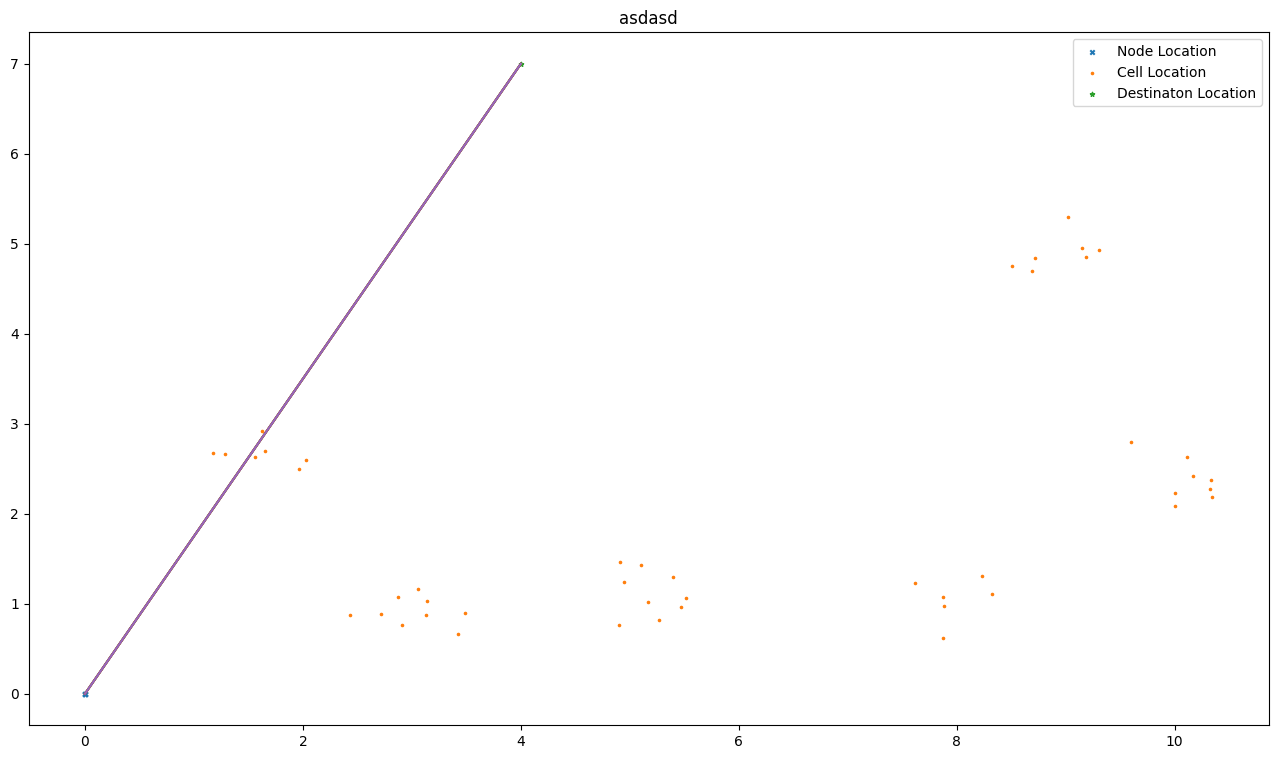

In [15]:
plotPolicy(smallcell1, np.zeros(shape=(52, 6)), 'asdasd')

## Value and Modified Policy Iteration over array of dicount Factors (REFERENCE RESULTS FOR __Question 2.__)

Try out Q-iteration for one of the discount factors

Also loop over the betas and see effect of increasing beta..

In [50]:
smallcell1 = SmallCellNet(46, 5, "E:\\mustafa\\_Btech mech\\Salapaka Reseach Group\\Matlab\\ParaMDP\\para3.mat");
print(smallcell1.state())
smallcell1.setState(1)
print(smallcell1.cellLocations[3])
print(smallcell1.step(0))

(0,)
[0. 0.]
[[(0,), 14.999999999999986, 0.9, [-8.0, -14.0, 0, 0, 0, 0, 0, 0, 0, 0]], [(0,), 14.999999999999986, 0.1, [-8.0, -14.0, 0, 0, 0, 0, 0, 0, 0, 0]]]


In [458]:
verificationParams = [5.007172447314836, 4.739229358920149, 4.583635987485419, 5.560810885490961, 7.654917383332541, 3.317342581767660,
6.267291265380822, 4.612761646327473, 4.078552812091590, 4.005094924238611];
smallcell1.update_params(params=verificationParams);
smallcell1.parameters();
smallcell1.update_cost_matrix();
smallcell1.update_grad_matrix();

In [56]:
smallcell1.C[4, 0, 0]
smallcell1.G[4, 0 ,0]

array([  0.,   0.,   0.,   0.,   0.,   0.,  -8., -14.,   0.,   0.])

In [60]:
import time;

In [61]:
V_QI = np.zeros(shape = (*smallcell1.state_space_shape(), *smallcell1.act_space_shape()));
beta_array = [0.001011]; # [0.1, 1, 2, 4, 8, 10];
for bet in beta_array:
    st = time.time();
    [finalVal, finalPol, train_params] = QIteration(smallcell1, V_QI, state_space=state_space, action_space=act_space,gamma=0.9, beta=bet, n_iters=201, allow_print=True, reward2cost=1);
    print(f'Execution Time: {time.time() - st} seconds');
    pol_det = (finalPol > 0.5)*1; #make the NPG policy deterministic by determining action as 1 if the probability is greater than 1
    # plotResults(pol_det, title=f'Final Policy, $\\beta$ = {bet}');

iter: 0 	 Delta Value(infinity Norm): 1448.4059487801806
iter: 1 	 Delta Value(infinity Norm): 1046.3242779954185
iter: 2 	 Delta Value(infinity Norm): 824.178991431042
iter: 3 	 Delta Value(infinity Norm): 661.1592671744866
iter: 4 	 Delta Value(infinity Norm): 533.3155427836664
iter: 5 	 Delta Value(infinity Norm): 431.0739463769023
iter: 6 	 Delta Value(infinity Norm): 348.7430096532644
iter: 7 	 Delta Value(infinity Norm): 282.25961893104704
iter: 8 	 Delta Value(infinity Norm): 228.50435429629033
iter: 9 	 Delta Value(infinity Norm): 185.01210046522556
iter: 10 	 Delta Value(infinity Norm): 149.810788675426
iter: 11 	 Delta Value(infinity Norm): 121.31387377241481
iter: 12 	 Delta Value(infinity Norm): 98.24139191906215
iter: 13 	 Delta Value(infinity Norm): 79.5591769398352
iter: 14 	 Delta Value(infinity Norm): 64.43095242720483
iter: 15 	 Delta Value(infinity Norm): 52.18012345038187
iter: 16 	 Delta Value(infinity Norm): 42.259113201637774
iter: 17 	 Delta Value(infinity Norm)

c:\Users\Mustafa\Python\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


In [62]:
finalPol[-1]

array([0. , 0.2, 0.2, 0.2, 0.2, 0.2])

## G Iteration to determine fixed point of gradient

Now, next apply GIteration on the mode, with the optimal policy obtained, to determine the fixed point of the gradient bellman equation for each parameter

In [65]:
#initializae the initial value for the GIteration
V_GI = np.zeros((n+f+1, f*2));
st = time.time();
[finalGVal, train_params] = GIteration(smallcell1, V_GI, finalPol, state_space, act_space, gamma=0.9, beta = 0.001011,
n_iters = 500, allow_print=True, reward2cost=1);
print(f'Execution Time: {time.time() - st} seconds');

iter: 42 	 Delta Value(infinity Norm): 3.99797762096199e-0553
Policy and Params:	for G, 9.073428078452004e-06 < 1e-5, Hence stopping GIteration
Execution Time: 0.04612159729003906 seconds


In [67]:
smallcell1.G[4,0,0]

array([  0.,   0.,   0.,   0.,   0.,   0.,  -8., -14.,   0.,   0.])

In [69]:
finalGVal[...,0]

array([ 0.        , -1.37530947, -0.7092879 , -0.7092879 , -0.7092879 ,
       -0.7092879 , -1.38805856, -1.27702757, -1.24291545, -1.14414262,
       -1.10618852, -1.26738084, -1.41359514, -1.65875498, -1.78202729,
       -1.93896431, -1.729637  , -1.91519881, -1.81217112, -1.81039211,
       -1.71516148, -1.55848891, -2.44635247, -2.66740466, -2.65300747,
       -2.4499523 , -2.62431106, -2.58031115, -2.46150901, -2.54136605,
       -2.5201711 , -3.67995164, -3.64660256, -3.5182915 , -3.51572357,
       -3.42425203, -3.51854809, -4.40336139, -4.39869323, -4.32133321,
       -4.13727214, -4.34145942, -4.28290329, -4.40624821, -4.28327811,
       -3.98952469, -4.032709  , -3.81024424, -3.97622515, -3.81932118,
       -3.93131298, -3.74469687])

In [71]:
np.sum(finalGVal, axis=0)

array([-135.09890354,  -97.10851716, -135.09890354,  -97.10851716,
       -135.09890354,  -97.10851716, -135.09890354,  -97.10851716,
       -135.09890354,  -97.10851716])

## Parameter update via gradient decent

Now we apply the parameter optimization routine on the model to optimize the parameters for the fixed optimal policy at the given beta

In [72]:
st = time.time()
train_params = optimizeParams(smallcell1, V_GI, finalPol, state_space, act_space, gamma=0.9, beta = 0.001011, epsilon=0.0001,
n_iters = 500, gd_iters= 200, allow_print=True, reward2cost=1);
print(f'Execution Time: {time.time() - st} seconds');

Execution Time: 2.7252063751220703 seconds004327875187711605 	 Infinity Norm: 3.28608349973829773


In [73]:
smallcell1.parameters()

array([2.11957297, 1.52362001, 2.11957297, 1.52362001, 2.11957297,
       1.52362001, 2.11957297, 1.52362001, 2.11957297, 1.52362001])

[2.11957297 1.52362001] -> [4. 7.]
[2.11957297 1.52362001] -> [4. 7.]
[2.11957297 1.52362001] -> [4. 7.]
[2.11957297 1.52362001] -> [4. 7.]
[2.11957297 1.52362001] -> [4. 7.]


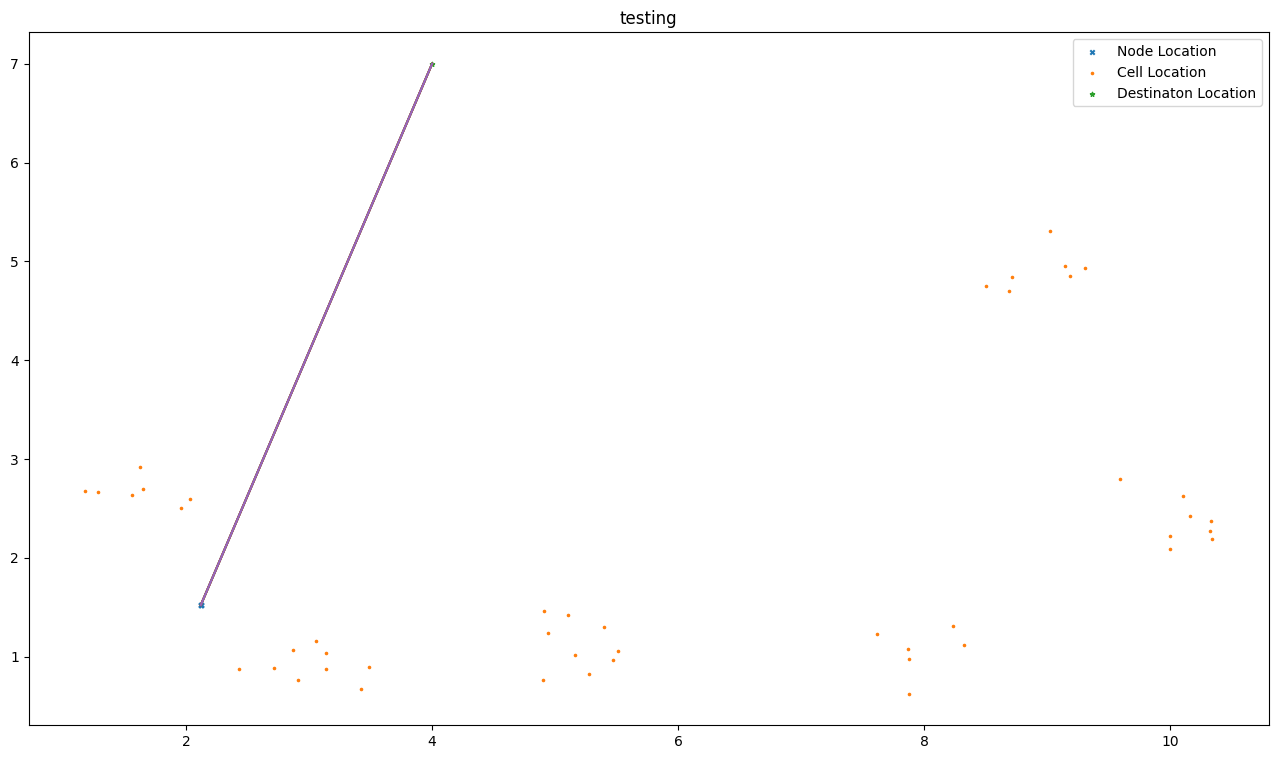

In [74]:
plotPolicy(smallcell1, np.zeros(shape = (52,6)), 'testing')

## Combined Optimization of policy and parameters

Now we apply the parameter and policy optimization routine to obtain combined optimal result for policy and parameters for a given beta

In [75]:
smallcell1.init_params();
smallcell1.init_cost_matrix();
smallcell1.init_grad_matrix();
smallcell1.init_action_mask();
smallcell1.parameters()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [77]:
smallcell1.G[4,0,0]

array([  0.,   0.,   0.,   0.,   0.,   0.,  -8., -14.,   0.,   0.])

In [112]:
verificationParams = [5.007172447314836, 4.739229358920149, 4.583635987485419, 5.560810885490961, 7.654917383332541, 3.317342581767660,
6.267291265380822, 4.612761646327473, 4.078552812091590, 4.005094924238611];
smallcell1.update_params(params=verificationParams);
smallcell1.parameters()

[5.007172447314836,
 4.739229358920149,
 4.583635987485419,
 5.560810885490961,
 7.654917383332541,
 3.31734258176766,
 6.267291265380822,
 4.612761646327473,
 4.07855281209159,
 4.005094924238611]

In [78]:
[finalPol, train_params] = optimizePolicyNParams(smallcell1, gamma = 0.9, beta = 0.001011, epsilon=0.0001, n_iters=50,
n_iters_qi=201, gd_iters=200, n_iters_gi=500, allow_print=True, reward2cost=1);

c:\Users\Mustafa\Python\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


iter: 13 	 Delta Q Value(infinity Norm): 0.044325844211016374 	 Q-Infinity Norm: 6804.775991262195
Policy and Params:	for Q, 6.513931431091027e-06 < 1e-10, Hence stopping Iteration


In [79]:
smallcell1.parameters()

array([5.30193102, 3.81123   , 5.30193102, 3.81123   , 5.30193102,
       3.81123   , 5.30193102, 3.81123   , 5.30193102, 3.81123   ])

[5.30193102 3.81123   ] -> [4. 7.]
[5.30193102 3.81123   ] -> [4. 7.]
[5.30193102 3.81123   ] -> [4. 7.]
[5.30193102 3.81123   ] -> [4. 7.]
[5.30193102 3.81123   ] -> [4. 7.]


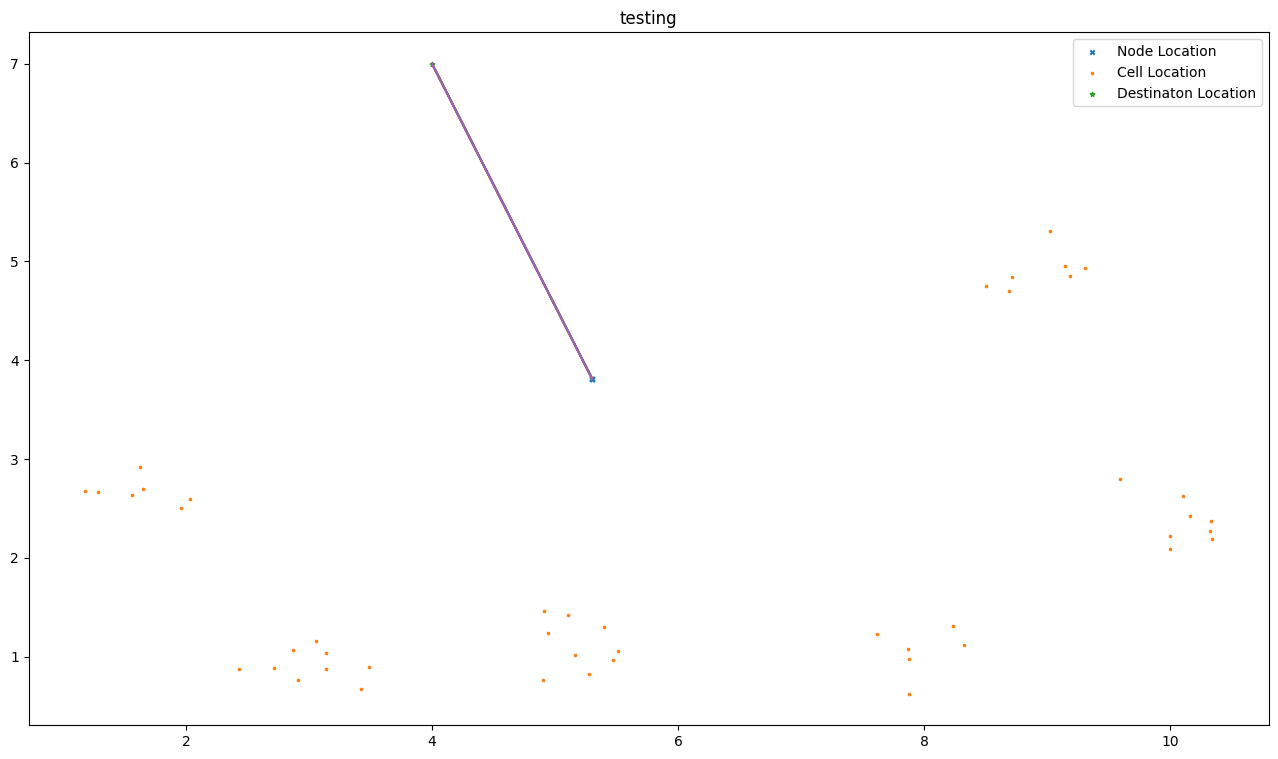

In [80]:
plotPolicy(smallcell1, np.zeros(shape=(52,6)), 'testing')

## Annealed Combined optimization of Policy and Parameters

Finally we carry out combined optimizaition of policy and parameters while annealing the inverse temperature

In [81]:
smallcell1.init_params();
smallcell1.init_cost_matrix();
smallcell1.init_grad_matrix();
smallcell1.init_action_mask();
smallcell1.parameters()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [86]:
smallcell1.G[4,0,0]

array([  0.,   0.,   0.,   0.,   0.,   0.,  -8., -14.,   0.,   0.])

0.001011

In [87]:
finalPol = optimizePolicyNParams_annealed(smallcell1, gamma = 0.9, beta_init = 0.001, beta_max= 4, beta_grow=0.01, sigma=0.01,
epsilon=0.0001, n_iters=50, n_iters_qi=201, gd_iters=200, n_iters_gi=500, allow_print=True, reward2cost=1);

@beta = 0.001


c:\Users\Mustafa\Python\Python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


iter: 13 	 Delta Q Value(infinity Norm): 0.044325851235043956 	 Q-Infinity Norm: 6879.407661362457
Policy and Params:	for Q, 6.44326567300204e-06 < 1e-10, Hence stopping Iteration
@beta = 0.011
iter: 2 	 Delta Q Value(infinity Norm): 0.005760610695460855 	 Q-Infinity Norm: 643.6617283686168
Policy and Params:	for Q, 8.949748666992094e-06 < 1e-10, Hence stopping Iteration
@beta = 0.020999999999999998
iter: 3 	 Delta Q Value(infinity Norm): 0.0005923475089844032 	 Q-Infinity Norm: 346.7236363189771
Policy and Params:	for Q, 1.7084139843280204e-06 < 1e-10, Hence stopping Iteration
@beta = 0.031
iter: 5 	 Delta Q Value(infinity Norm): 0.0022086206603546543 	 Q-Infinity Norm: 241.35951368614144
Policy and Params:	for Q, 9.150750374922844e-06 < 1e-10, Hence stopping Iteration
@beta = 0.041
iter: 3 	 Delta Q Value(infinity Norm): 0.00161543796599517 	 Q-Infinity Norm: 187.39522871319045
Policy and Params:	for Q, 8.620486108894522e-06 < 1e-10, Hence stopping Iteration
@beta = 0.051000000000000

In [135]:
smallcell1.parameters()

array([6.03647869, 5.55106717, 3.90205888, 3.07984966, 3.836689  ,
       5.01827735, 3.35513094, 4.89615925, 7.53447205, 3.73902655])

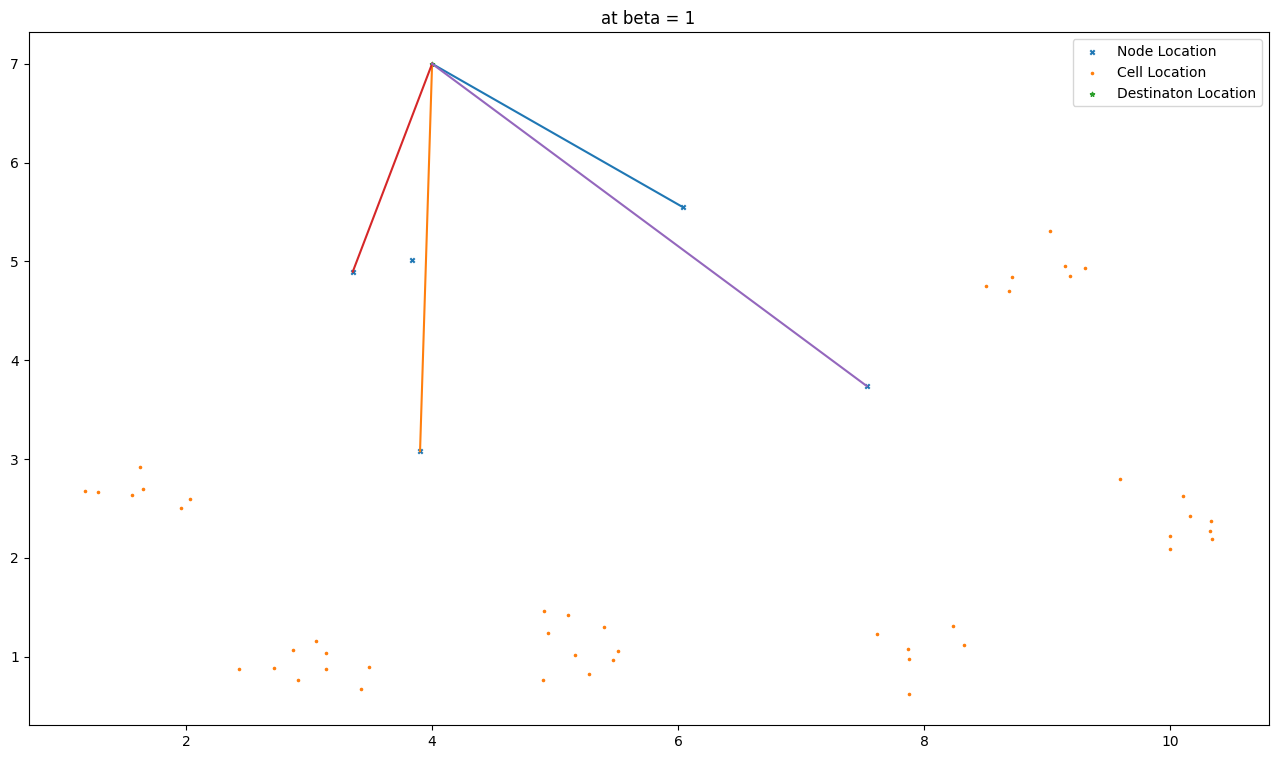

In [137]:
plotPolicy(smallcell1, finalPol, 'at beta = 1');

In [88]:
smallcell1.parameters()

array([2.84171164, 4.89867292, 4.06203553, 3.07469795, 7.53604697,
       3.73426285, 4.03496863, 5.01444044, 6.08486882, 5.54096396])

[2.84171164 4.89867292] -> [4. 7.]
[4.06203553 3.07469795] -> [4.03496863 5.01444044]
[7.53604697 3.73426285] -> [6.08486882 5.54096396]
[4.03496863 5.01444044] -> [4. 7.]
[6.08486882 5.54096396] -> [4. 7.]
[1.96016213 2.50033069] -> [2.84171164 4.89867292]
[1.65174273 2.70014656] -> [2.84171164 4.89867292]
[1.55698682 2.63460299] -> [2.84171164 4.89867292]
[1.28261786 2.66478511] -> [2.84171164 4.89867292]
[1.1771898  2.67959988] -> [2.84171164 4.89867292]
[1.62494626 2.92460785] -> [2.84171164 4.89867292]
[2.0310971 2.5923048] -> [2.84171164 4.89867292]
[2.71209664 0.88874371] -> [4.06203553 3.07469795]
[3.05451971 1.16122474] -> [4.06203553 3.07469795]
[3.49045589 0.9008766 ] -> [4.06203553 3.07469795]
[2.90899115 0.75996149] -> [4.06203553 3.07469795]
[3.42444062 0.66908677] -> [4.06203553 3.07469795]
[3.13825258 1.03462334] -> [4.06203553 3.07469795]
[3.13331089 0.87185227] -> [4.06203553 3.07469795]
[2.86878137 1.07095336] -> [4.06203553 3.07469795]
[2.43357979 0.88022862] -> [4.

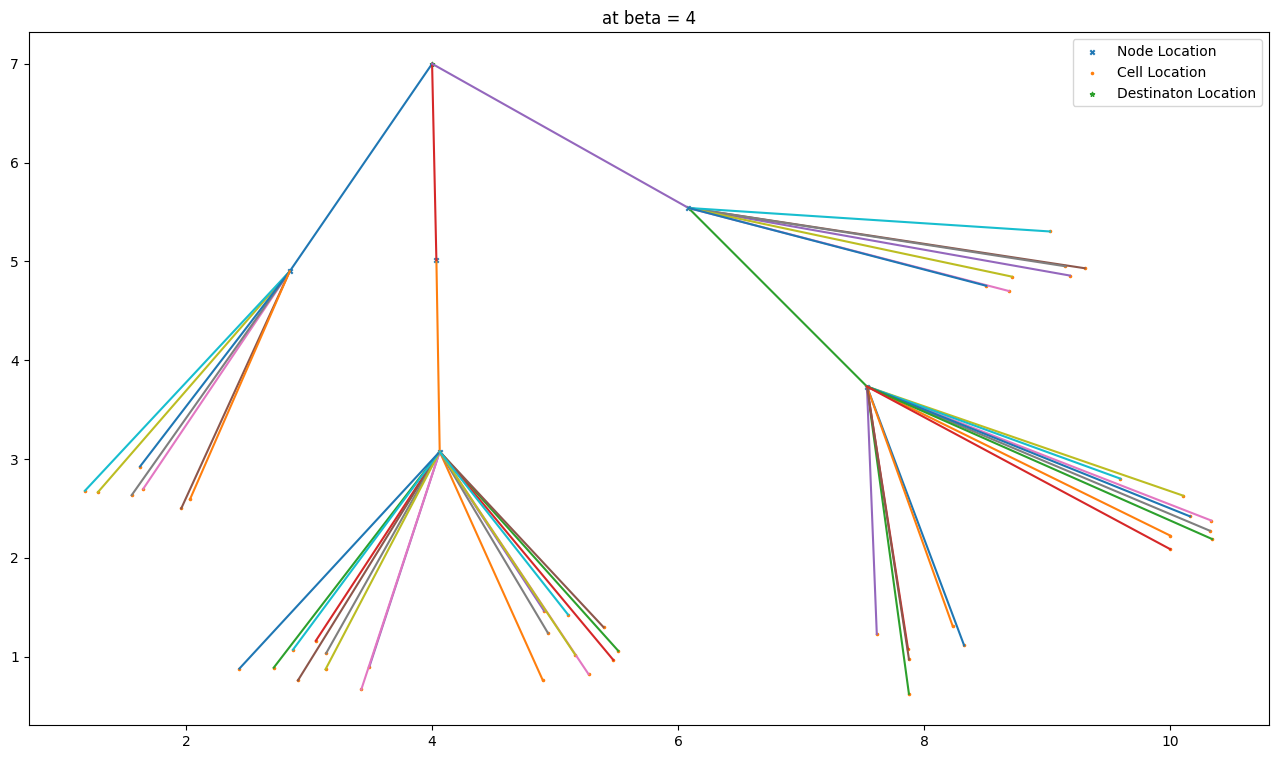

In [110]:
plotPolicy(smallcell1, finalPol, 'at beta = 4', plotNodes=True);

In [143]:
finalPol[1:6]

array([[1.00000000e+00, 0.00000000e+00, 2.35858371e-35, 4.66085955e-12,
        5.71096949e-26, 5.82653057e-34],
       [2.84108482e-06, 1.43919346e-15, 0.00000000e+00, 9.99976720e-01,
        2.04393367e-05, 5.01467127e-36],
       [1.00000000e+00, 5.21163912e-20, 1.83244237e-28, 0.00000000e+00,
        7.52925172e-14, 7.92632433e-53],
       [9.99999940e-01, 5.09619648e-28, 2.98906417e-27, 6.00869032e-08,
        0.00000000e+00, 2.96606666e-66],
       [4.91491363e-13, 1.00000000e+00, 1.41047229e-22, 1.21661591e-11,
        5.70472291e-31, 0.00000000e+00]])